In [1]:
import csv
import json
from collections import defaultdict
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from operator import itemgetter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/treven/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_data():
    data = []
    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                if label[i]=='total_votes' or label[i]=='number_of_upvotes' or label[i]=='number_of_downvotes' or label[i]=='score' or label[i]=='number_of_comments':
                    d[label[i]] = int(elem)
                else:
                    d[label[i]] = elem
                    #judge if element it is empty
            data.append(d)
    return data

In [3]:
data = load_data()
comments_sorted_data = sorted(data, key=itemgetter('number_of_comments'), reverse=True)
votes_sorted_data = sorted(data, key=itemgetter('total_votes'), reverse=True)

In [4]:
def title():
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)

    # word count in top 25000 titles with most comment numbers
    for d in comments_sorted_data[0:25000]:
        r = ''.join([c for c in d['title'].lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    # remove English stopwords
    for w in stopwords.words("english"):
        if w in wordCount:
            wordCount.pop(w)

    #print(len(wordCount))
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    # take top 1000 words to be targets
    words = [x[1] for x in counts[:1000]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    title_comment_list = []
    for d in data:
        title_comment_num = 0
        for i,w in enumerate(words):
            if w in d['title']:
                title_comment_num = title_comment_num + (1000-i)
        title_comment_list.append(title_comment_num)

    return title_comment_list

In [5]:
import re
def get_time_feature(d):
    # Create dummy variables based on exploratory analysis of this dataset and previous plots
    time_feature = []  #night(22-1),sleep time(2-7),morning(8-11),afternoon(12-17),[evening(18-21) is omitted]
                       #UTC+8,UTC+7,[UTC+0 is omitted]
    
    catchTime = re.compile("(.*)T(\d{2}):(\d{2}).*((-|\+)\d{2})")
    
    
    t = d['rawtime']
    m = catchTime.search(t)
    if m:
        d['hour'] = int(m.group(2))
        d['minute'] = int(m.group(3))
        if d['minute'] >= 30:
            d['time'] = (d['hour'] +1*0)%24
        else:
            d['time'] = d['hour']

        d['timezone'] = int(m.group(4))
        d['UTCtime'] = (d['time'] + d['timezone'])%24
            
    if d['UTCtime'] >= 22 or d['UTCtime'] <= 1:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 2 and d['UTCtime'] <= 7:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 8 and d['UTCtime'] <= 11:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['UTCtime'] >= 12 and d['UTCtime'] <= 17:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -8:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -7:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    return time_feature

In [11]:
raw_time_list = []
for d in data:
    raw_time_list.append(get_time_feature(d))

In [6]:
# submission time feature
def submission():
    ID = '-1'
    submission_list = []

    # original data is sorted in image_ID, count submission times before current submission
    for d in data:
        if d['image_id'] == ID:
            count = count + 1
            d['submission_time'] = count
        else:
            count = 0
            ID = d['image_id']
            d['submission_time'] = count

    for d in data:
        submission_list.append(d['submission_time'])

    return submission_list

In [7]:
# username feature
def username():
    with open('all_user_profile.json', 'r') as f:
        all_user_profile = json.load(f)
    #post_list = []
    #user_votes_list = []
    #user_votes_dict = {}
    user_comment_list = []
    user_comment_dict = {}
    for user in all_user_profile:
        #post_list.append(user.get('num_of_post'))
        #user_votes_dict[user.get('username')] = user.get('avg_votes')
        user_comment_dict[user.get('username')] = user.get('avg_comments')

    for d in data:
        if d['username']=='':
            user_comment_list.append(d['number_of_comments'])
        elif d['username'] in user_comment_dict:
            user_comment_list.append(user_comment_dict[d['username']])
        #if d['username'] in user_votes_dict:
            #user_votes_list.append(user_votes_dict[d['username']])

    return user_comment_list

In [8]:
#subreddit feature
def subreddit():
    with open('all_subreddit_profile.json', 'r') as f:
        all_subreddit_profile = json.load(f)
    #post_list = []
    sub_comment_list = []
    sub_comment_dict = {}
    sub_votes_list = []
    sub_votes_dict = {}
    for sub in all_subreddit_profile:
        # post_list.append(sub.get('num_of_post'))
        #sub_votes_dict[sub.get('subreddit')] = sub.get('avg_votes')
        sub_comment_dict[sub.get('subreddit')] = sub.get('avg_comments')

    for d in data:
        if d['subreddit']=='':
            sub_comment_list.append(d['number_of_comments'])
        elif d['subreddit'] in sub_comment_dict:
            sub_comment_list.append(sub_comment_dict[d['subreddit']])
        #if d['subreddit'] in sub_votes_dict:
            #sub_votes_list.append(sub_votes_dict[d['subreddit']])

    return sub_comment_list

In [67]:
with open('kmean_d.json', 'r') as f:
        Kmeans_title = json.load(f)

In [70]:
with open('title_len_list.json', 'r') as f:
        title_len_list = json.load(f)

In [73]:
submission_list = submission()

comment_feature_list = []
comment_label_list = []
for i in range(len(data)):
    large = 0
    comment_feature_list.append([Kmeans_title[i],submission_list[i],title_len_list[i],raw_time_list[i][0],raw_time_list[i][1],raw_time_list[i][2],raw_time_list[i][3],raw_time_list[i][4],raw_time_list[i][5]])
    if data[i]['number_of_comments'] > 15: large = 1
    comment_label_list.append(large)

print "feature[title_keyword,submission_time,username,subreddit]:",comment_feature_list[0]
print "label[comment_number]:",comment_label_list[0]

feature[title_keyword,submission_time,username,subreddit]: [5, 0, 4, 0, 1, 0, 0, 0, 1]
label[comment_number]: 1


In [74]:
comment_feature_list[11]

[3, 11, 11, 0, 0, 1, 0, 0, 1]

In [75]:
comment_label_list[11]

0

In [76]:
import os
import time
from sklearn import metrics
import numpy as np
import pickle

import sys

In [77]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [80]:
X_train, X_test, y_train, y_test = train_test_split(comment_feature_list, comment_label_list, random_state=4)

In [81]:
X_train[0:10]

[[5, 5, 8, 0, 0, 0, 1, 0, 1],
 [5, 16, 7, 1, 0, 0, 0, 0, 1],
 [5, 1, 6, 0, 1, 0, 0, 0, 1],
 [5, 3, 8, 0, 1, 0, 0, 0, 1],
 [5, 0, 9, 0, 0, 1, 0, 0, 1],
 [5, 12, 3, 0, 0, 1, 0, 0, 0],
 [5, 4, 1, 1, 0, 0, 0, 0, 1],
 [5, 4, 2, 0, 0, 0, 0, 0, 0],
 [5, 3, 5, 0, 1, 0, 0, 0, 0],
 [9, 8, 8, 0, 0, 0, 1, 0, 1]]

In [82]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [83]:
len(X_train)

99230

In [84]:
len(X_test)

33077

In [85]:
X_train[0:10]

array([[ 0.09891108, -0.25810155,  0.31366411, -0.45460294, -0.63410438,
        -0.44275513,  1.72046876, -0.18079946,  0.71826926],
       [ 0.09891108,  0.56022825,  0.09901414,  2.19972183, -0.63410438,
        -0.44275513, -0.58123694, -0.18079946,  0.71826926],
       [ 0.09891108, -0.55567602, -0.11563583, -0.45460294,  1.57702742,
        -0.44275513, -0.58123694, -0.18079946,  0.71826926],
       [ 0.09891108, -0.40688878,  0.31366411, -0.45460294,  1.57702742,
        -0.44275513, -0.58123694, -0.18079946,  0.71826926],
       [ 0.09891108, -0.63006963,  0.52831408, -0.45460294, -0.63410438,
         2.25858476, -0.58123694, -0.18079946,  0.71826926],
       [ 0.09891108,  0.26265378, -0.75958574, -0.45460294, -0.63410438,
         2.25858476, -0.58123694, -0.18079946, -1.39223556],
       [ 0.09891108, -0.33249516, -1.18888568,  2.19972183, -0.63410438,
        -0.44275513, -0.58123694, -0.18079946,  0.71826926],
       [ 0.09891108, -0.33249516, -0.97423571, -0.45460294, -0

## KNN Classifier

In [86]:
# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.726789007467


In [87]:
y_pred[0:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0])

In [27]:
from sklearn.cross_validation import cross_val_score
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[ 0.85115388  0.8523632   0.84641741  0.84621586  0.8477275   0.85065001
  0.84661897  0.84359569  0.85155699  0.85367328]


In [28]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.8251234505693843, 0.82376297490678208, 0.84402902348080211, 0.83804293056535317, 0.84899727904867484, 0.84387785951829086, 0.85101279854882583, 0.84676005240350705, 0.85132520407134948, 0.84796936410359769, 0.85166784238637516, 0.84812052806610905, 0.85189962712889256, 0.8494507709362088, 0.85213141187140984, 0.84973294366622998, 0.8520608686889044, 0.84995465081124666, 0.85188954953139162, 0.85028721152877151, 0.8516879975813767, 0.85031744432127387, 0.85135543686385162, 0.84982364204373684, 0.85105310893882913, 0.84985387483623887, 0.85075078101380641, 0.84961201249622087, 0.85047868588128583, 0.84869495112365212]


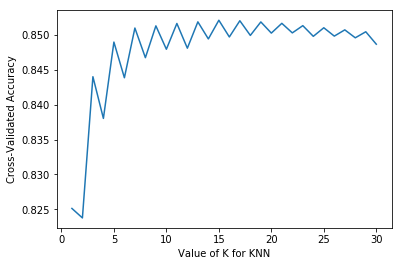

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [31]:
# The optimal value of K is 15
knn = KNeighborsClassifier(n_neighbors=15)
knn_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(knn_scores.mean())

0.852131411871


## Multinomial Naive Bayes Classifier

In [89]:
# Multinomial Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB_scores = cross_val_score(NB, X_train, y_train, cv=10, scoring='accuracy')
print(NB_scores.mean())

0.678847122846


## Logistic Regression Classifier

In [88]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print(LR_scores.mean())

0.576176559508


In [34]:
# search for an optimal value of C for LR
C_range = [0.01,0.1,1.0,10.0,100.0,1000.0]
C_scores = []
for c in C_range:
    LR = LogisticRegression(C = c, penalty='l2', class_weight = 'balanced')
    scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
    C_scores.append(scores.mean())
print(C_scores)

[0.85219187745641434, 0.8520507910914038, 0.85195001511639634, 0.85195001511639634, 0.85195001511639634, 0.85195001511639634]


In [35]:
# The optimal value of C is 0.01
LR = LogisticRegression(C = 0.01, penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print(LR_scores.mean())

0.852191877456


## test set

In [94]:
LR.fit(X_train,y_train)
theta = LR.coef_
predict = LR.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )
print(theta)
print predict[0:100]

precision: 33.01%, recall: 71.75%
accuracy: 57.54%
[[-0.0229571  -0.63441468  0.06104329  0.07363628 -0.00682139 -0.01157549
  -0.02113963  0.03486983  0.32093576]]
[1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0
 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0]


## Random Forest Classifier
特征很少，用随机森林应该效果不明显

In [37]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100,class_weight = 'balanced')
RF_scores = cross_val_score(RF, X_train, y_train, cv=10, scoring='accuracy')
print(RF_scores)

[ 0.8653633   0.86173536  0.86425476  0.86153381  0.86294467  0.86334778
  0.8653633   0.85941751  0.86768114  0.86717726]


In [38]:
print(RF_scores.mean()) # 居然不错

0.863881890557


## Decision Tree Classifier

In [44]:
from sklearn import tree
# max_depth = 4, 限制树的最大深度4,其实特征少的时候不用限制这个深度，但不知道为什么这里限制了之后准确率提高
DT = tree.DecisionTreeClassifier(class_weight = 'balanced',max_depth = 4) 
DT_scores = cross_val_score(DT, X_train, y_train, cv=10, scoring='accuracy')
print(DT_scores.mean())

0.855930666129


## AB(AdaBoost) Classifier
未调参，根据经验选择的参数

In [45]:
from sklearn.ensemble import AdaBoostClassifier
# 一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50
#对于同样的训练集拟合效果，较小的νν意味着我们需要更多的弱学习器的迭代次数。通常我们用步长和迭代最大次数一起来决定算法的拟合效果。
#所以这两个参数n_estimators和learning_rate要一起调参。一般来说，可以从一个小一点的νν开始调参，默认是1
Ada= AdaBoostClassifier(n_estimators=200,learning_rate=0.8)
Ada_scores = cross_val_score(Ada, X_train, y_train, cv=10, scoring='accuracy')
print(Ada_scores)

[ 0.87322382  0.87090598  0.87009977  0.86677416  0.86969666  0.87352615
  0.86566563  0.86919278  0.87090598  0.87161141]


In [46]:
print(Ada_scores.mean())

0.8701602338


## SVM
未调参，根据经验选择的参数

In [47]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=0.1, gamma=1, probability=True)
svm_scores = cross_val_score(svm, X_train, y_train, cv=3, scoring='accuracy')
print(DT_scores)

KeyboardInterrupt: 

In [88]:
print(DT_scores.mean())

0.855930666129


## Ridge

In [93]:
from sklearn import linear_model
LRR = linear_model.Ridge(1.0, fit_intercept=False)
LRR.fit(X_train,y_train)
theta = LRR.coef_

In [94]:
theta

array([ 0.00271471, -0.05308208,  0.15146413,  0.03709293])

In [97]:
print X_train[0:10]

[[ 0.91289318 -0.25810155 -0.30888918 -0.09360251]
 [-0.84530389  0.56022825 -0.32705685 -1.66334492]
 [ 0.10402453 -0.55567602 -0.25763521  0.81855247]
 [ 0.01909536 -0.40688878  0.50987995 -0.09360251]
 [-0.67422062 -0.63006963  4.03488423  1.05025454]
 [-1.04456078  0.26265378 -0.24055056  0.81855247]
 [-1.0543603  -0.33249516 -0.33451616 -0.09360251]
 [-1.0543603  -0.33249516 -0.33451616 -0.09360251]
 [-0.17199526 -0.40688878 -0.3174315  -0.09360251]
 [ 0.4376165  -0.03492069 -0.29180452 -0.95105792]]
